# 6章 GLMの応用範囲を広げる-ロジスティック回帰など-
* ポアソン分布以外の確率分布を扱う
* GLMのオフセット項を使い方を説明

## 6.1. 様々な種類のデータで応用できるGLM

Q. GLMの特徴は？

A.
* 確率分布、リンク関数、線形予測子の組み合わせを指定することによって、様々なタイプのデータを表現できること

### PythonでGLMの構築に使える確率分布の一部（できたら）

* 未作成

* GLMなど使わなくとも、応答変数を変数変換して直線回帰すれば良いと考えている人もいるが、その方法はリンク関数とは全く別のもの

## 6.2. 例題：上限のあるカウントデータ

* ポアソン分布は上限のないカウントデータを表現
* 二項分布は上限のあるカウントデータのばらつきを表すために用いる
    * 例）N個体の実験対象に同じ処理をしたら、y個体で陽性、N-y個体で陰性。N個という上限がある。


### 例題のデータについて

* ここでは、観察種子数$N_i$をどの個体でも8個とする。
* 応答変数である生存種子数$y_i$は0〜8の整数となる。
* ある個体$i$の種子の生存確率$q_i$は「ある個体$i$から得られた1個の種子が生きている確率」
* 体サイズ$x_i$、肥料の処理の有無$f_i$
* ある個体の生存確率$q_i$が$x_i$や$f_i$といった説明変数によってどう変化するか調べる。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

np.random.seed(160)

d = pd.read_csv("data4a.csv",dtype={"y": int,"x":float, "f":"category"})

/Users/takizawa/dev/python/books/midori/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
d.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [3]:
d.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [4]:
d.f.describe()

count     100
unique      2
top         T
freq       50
Name: f, dtype: object

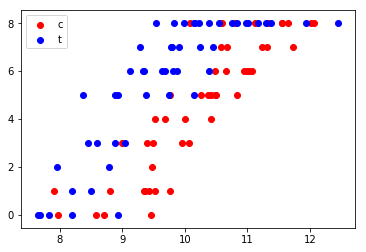

In [5]:
x_c = d.x[d.f == "C"]
y_c = d.y[d.f == "C"]

x_t = d.x[d.f == "T"]
y_t = d.y[d.f == "T"]

plt.scatter(x_c,y_c,c="red",label="c")
plt.scatter(x_t,y_t,c="blue",label="t")
plt.legend()
plt.show()

* 体サイズ$x_i$が大きくなると、生存種子数$y_i$は多くなりそうだ
* 肥料をやる（$f_i = T$)と、生存種子数$y_i$は多くなりそうだ

## 6.3. 二項分布で表現する「あり・なし」カウントデータ

* 「N個のうちy個が生存していた」といった構造のカウントデータを統計モデルで表現するときには「二項分布(binomial distribution)」がよく使われる。
* 本事例では$N_i = 8$ という上限があるため、ポアソン分布では観測データを表現できない（ポアソン分布は0以上で上限不明のカウントデータを扱う）
* 二項分布の確率分布は下記と定義される。
$$
p(y | N,q) = \binom Ny q^y (1-q)^{N-y}
$$
* $p(y | N,q)$は$N$個中の$y$個で事象が生起する確率。
* $\binom Ny$は場合の数で、「$N$個の観察種子の中から$y$個の生存種子を選び出す場合の数。

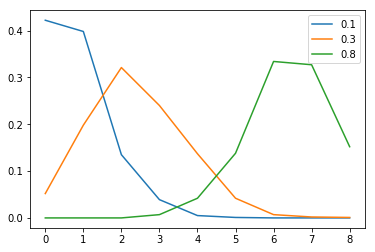

In [6]:
q_list = [0.1,0.3,0.8]
p_dicts =dict()
for q in q_list:
    p_dict = dict()
    for i in range(0,9):
        p_dict.update({i:0})
    for _ in range(1000):
        rnd = np.random.binomial(8,p=q)
        p_dict[rnd] += 1
    
    for i in range(0,9):
        p_dict[i] /= 1000
        
    p_dicts.update({q: p_dict})

for param,dictionary in p_dicts.items():
    plt.plot(list(dictionary.keys()),list(dictionary.values()),label=str(param))
    
plt.legend()

## 6.4. ロジスティック回帰とロジットリンク関数

* 二項分布を使ったGLMの一つである、ロジスティック回帰(logistic regression)の統計モデルを扱う。

### 6.4.1. ロジットリンク関数

* GLMは確率分布・リンク関数・線形予測子を指定する統計モデル
* ロジスティック回帰では確率分布は二項分布、リンク関数はロジットリンク関数
* 二項分布では、事象が生起する確率$q_i$をパラメーターとして指定する必要がある。この$q_i$は確率なので、$0\leqq q_i \leqq 1$。

* ロジットリンク関数の前に、ロジスティック関数について説明する。関数系は下記。
$$
q_i = logistic (z_i) = \frac{1} {1+\exp(-z_i)}
$$
変数 $z_i$ は線形予測子 $z_i = \beta_1 + \beta_2 x_i + ...$
* ロジスティック関数を作図する。

In [7]:
def sigmoid(x):
    return 1 /(1+np.exp(-x))
x = np.arange(-6,6,0.1)
y = sigmoid(x)

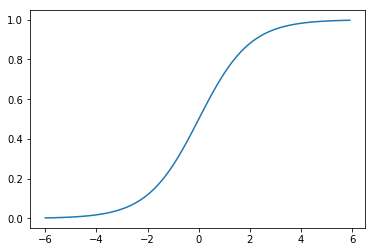

In [8]:
plt.plot(x,y)

* ロジスティック関数を変形すると下記。
$$
\log \frac{q_i} { 1-q_i} = z_i
$$
* この左辺のことをロジット関数という。
$$
logit(q_i) = \log \frac {q_i}{1-q_i}
$$
* ロジット関数はロジスティック関数の逆関数であり、ロジスティック関数の逆関数がロジット関数

### 6.4.2. パラメーター推定

* この統計モデルをデータに当てはめてパラメータを推定する。
* 尤度関数は下記。
$$
L({\beta_j}) = \prod_{ i } (N_i,y_i) q_{i}^{y_i} (1-q_i)^{N_i - y_i}
$$
（ある個体$i$から$N_i$個取り出したうちの生存種子数が$y_i$である確率を考え、それを全個体で掛け合わせれば良い。）
* 対数尤度関数は下記。
$$
\log L({\beta_j}) = \sum_{i} \left( \log (N_i,y_i) + y_i \log (q_i) + (N_i - y_i) \log (1-q_i) \right)
$$
* この$\log L$を最大にする推定値のセットを探し出すのが最尤推定
* ここで、確率$q_i$は{$\beta_1,\beta_2,\beta_3$}の関数であることに注意。

In [9]:
d.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [10]:
d.shape

(100, 4)

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.glm('y + I(N-y)~ x + f',data=d,family=sm.families.Binomial())

In [12]:
result = model.fit()

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Thu, 06 Jul 2017   Deviance:                       123.03
Time:                        01:08:11   Pearson chi2:                     13.7
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

* 図示する

In [14]:
df_test_c = pd.DataFrame()
df_test_c["x"] = np.linspace(7,12,100)
df_test_c["f"] = "C"
predict_c = result.predict(df_test_c)*8

df_test_t = pd.DataFrame()
df_test_t["x"] = np.linspace(7,12,100)
df_test_t["f"] = "T"
predict_t = result.predict(df_test_t)*8

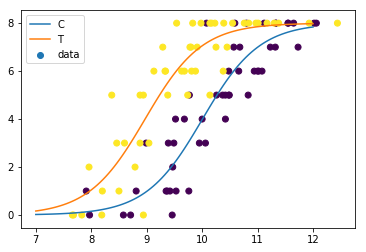

In [15]:
plt.plot(df_test_c.x,predict_c,label="C")
plt.plot(df_test_t.x,predict_t,label="T")
plt.scatter(d.x,d.y,c=d.f.cat.codes,label="data")
plt.legend()

In [16]:
x

array([ -6.00000000e+00,  -5.90000000e+00,  -5.80000000e+00,
        -5.70000000e+00,  -5.60000000e+00,  -5.50000000e+00,
        -5.40000000e+00,  -5.30000000e+00,  -5.20000000e+00,
        -5.10000000e+00,  -5.00000000e+00,  -4.90000000e+00,
        -4.80000000e+00,  -4.70000000e+00,  -4.60000000e+00,
        -4.50000000e+00,  -4.40000000e+00,  -4.30000000e+00,
        -4.20000000e+00,  -4.10000000e+00,  -4.00000000e+00,
        -3.90000000e+00,  -3.80000000e+00,  -3.70000000e+00,
        -3.60000000e+00,  -3.50000000e+00,  -3.40000000e+00,
        -3.30000000e+00,  -3.20000000e+00,  -3.10000000e+00,
        -3.00000000e+00,  -2.90000000e+00,  -2.80000000e+00,
        -2.70000000e+00,  -2.60000000e+00,  -2.50000000e+00,
        -2.40000000e+00,  -2.30000000e+00,  -2.20000000e+00,
        -2.10000000e+00,  -2.00000000e+00,  -1.90000000e+00,
        -1.80000000e+00,  -1.70000000e+00,  -1.60000000e+00,
        -1.50000000e+00,  -1.40000000e+00,  -1.30000000e+00,
        -1.20000000e+00,

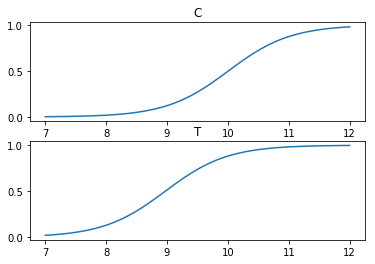

In [17]:
# predictを用いずに。
b1 = result.params[0]
b2 = result.params[2]
b3 = result.params[1]

x = np.linspace(7,12,100)
z_c = x*b2 + b1
z_t = x*b2 + b1 + b3
y_c = sigmoid(z_c)
y_t = sigmoid(z_t)

plt.subplot(2,1,1)
plt.plot(x,y_c)
plt.title("C")

plt.subplot(2,1,2)
plt.plot(x,y_t)
plt.title("T")

### 6.4.3. ロジットリンク関数の意味・解釈

* ロジスティック関数の逆関数であるロジット関数は
$$
logit(q_i)=\log \frac {q_i}{1-q_i}
$$
* これが線形予測子に等しいので
$$
\begin{equation}
\begin{split}
\frac {q_i} {1-q_i} &= \exp ( linear predictor) \\
&=\exp(\beta_1+\beta_2 x_i + \beta_3 f_i) \\
&=\exp(\beta_1) \exp(\beta_2 x_i) \exp(\beta_3 f_i)
\end{split}
\end{equation}
$$
* この左辺の$\frac {q_i}{1-q_i}$はオッズ(odds)と呼ばれる量。オッズは$\exp $(パラメーター$\times$要因)に比例する。
* このオッズの対数を取ると、
$$
\log \frac {q_i}{1-q_i} = \beta_1 + \beta_2 x_i + \beta_3 f_i
$$
* 「リスク」をオッズ比で表すことがある。個人$i$の生活習慣$X$が、ある病の発病に影響があり、その係数が$\beta_s$であるとする。その時、オッズ比は、
$$
\begin {equation}
\begin {split}
\frac {X odds}{nonX odds} &= \frac {\exp(X nonX common) \times \exp(\beta_s \times 1)} {\exp(X nonX common) \times \exp(\beta_s \times 0)}\\
&= \exp (\beta_s)
\end{split}
\end{equation}
$$

### 6.4.4. ロジスティック回帰のモデル選択

* 6.4.2.ではサイズx_iと施肥処理$f_i$を説明変数とするロジスティック回帰の統計モデルをデータに当てはめた。
* これが種子の生存数を最もよく予測するモデルなのかどうかは不明。
* AICによるモデル選択によって、ネストしているモデルなどの中から良い予測をするものを選ぶ。

* $AIC = -2 (\log L^* - k)$
* stepAICはPythonにはない。

In [18]:
formula_list = ['y + I(N-y)~ 1','y + I(N-y)~ f','y + I(N-y)~ x','y + I(N-y)~ x+f']

for formula in formula_list:
    model = smf.glm(formula,data=d,family=sm.families.Binomial())
    result = model.fit()
    print(formula,-2*(result.llf - (result.df_model+1)))

y + I(N-y)~ 1 644.409341662
y + I(N-y)~ f 637.759753457
y + I(N-y)~ x 364.345443284
y + I(N-y)~ x+f 272.211129285


In [19]:
model = smf.glm('y + I(N-y)~ 1',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -321.20
Date:                Thu, 06 Jul 2017   Deviance:                       499.23
Time:                        01:08:12   Pearson chi2:                     50.2
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5537      0.073      7.540      0.000       0.410       0.698
==============================================================================
"""

In [20]:
model = smf.glm('y + I(N-y)~ x',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -180.17
Date:                Thu, 06 Jul 2017   Deviance:                       217.17
Time:                        01:08:12   Pearson chi2:                     23.1
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7785      1.077    -12.789      0.000     -15.890     -11.667
x              1.4626      0.111     13.214      0.000       1.246       1.680
==============================================================================
"""

In [21]:
model = smf.glm('y + I(N-y)~ f',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -316.88
Date:                Thu, 06 Jul 2017   Deviance:                       490.58
Time:                        01:08:12   Pearson chi2:                     49.9
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3433      0.101      3.383      0.001       0.144       0.542
f[T.T]         0.4335      0.148      2.930      0.003       0.144       0.723
==============================================================================
"""

## 6.5.交互作用項の入った線形予測子

* 線形予測子$\beta_1 + \beta_2 x_i + \beta_3 f_i$をさらに複雑化して、交互作用(interaction)項を追加してみる。入れたものは下記。
$$
logit(q_i) = \beta_1 + \beta_2 x_i + \beta_3 f_i + \beta_4 x_i f_i
$$

In [22]:
model = smf.glm('y + I(N-y)~ x*f',data=d,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -132.81
Date:                Thu, 06 Jul 2017   Deviance:                       122.43
Time:                        01:08:12   Pearson chi2:                     13.6
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.5233      1.886     -9.821      0.000     -22.220     -14.827
f[T.T]        -0.0638      2.704     -0.024      0.981      -5.363       5.235
x              1.8525      0.186      9.983      0.000       1.489       2.216
x:f[T.T]       0.2163      0.280      0.772      0.440      -0.333       0.765
==============================================================================
"""

In [23]:
aic = -2*(result.llf - (result.df_model+1))
aic

273.61059672597389

*  本例題では、交互作用項を追加してもAICは下がった（予測能力は何も改善されなかった）
* むやみに交互作用項を入れないこと。
* 交互作用項を入れても、何を表しているんか解釈が難しいことがある。
* 現実のデータでは、説明変数では説明できない「個体差」「場所差」によるばらつきが発生する。それらを考慮していないGLMを当てはめた場合には、過度に複雑なモデルが選ばれる傾向がある。

## 6.6. 割り算値の統計モデリングはやめよう

* 二項分布とロジットリンク関数を使ったロジスティック回帰を使う利点の一つは、何かの生起確率を推定するときに、（観測データ)/(観測データ）といった割り算値を作り出す必要がなくなるということ
* 変形した観測値を統計モデルの応答変数にするのは不必要であるばかりでなく、場合によっては間違った結果を導きかねない。
* 情報が失われる。
* 変換された値の分布はどうなる？

### 6.6.1. 割り算値いらずのオフセット項わざ

* 「N個のうちy個で事象が生じる確率」は二項分布を使うことで、割り算値の使用は回避できた。
* ここでは人口密度のように、「単位面積あたりの個体数」といった概念について扱う。
* このようなときに便利なのがオフセット項わざである。

#### 森林の事例

* 面積が$A_i$である調査地$i$における人口密度は
$$
\frac {平均個体数 \lambda_i}{A_i} = 人口密度
$$
* 人口密度は正の量なので、指数関数と明るさ$x_i$依存性を組み合わせて下記のようにモデル化できる。
$$
\lambda_i = A_i \times 人口密度 = A_i \exp(\beta_1 + \beta_2 x_i)
$$
* これを変形すると、
$$
\lambda_i = \exp(\beta_1 + \beta_2 x_i + \log A_i)
$$
となり、$z_i=\beta_1 + \beta_2 x_i + \log A_i$を線形予測子とする対数リンク関数・ポアソン分布のGLMになる。
* 線形予測子の中でパラメーターがつかない$\log A_i$のような項をオフセット項と呼ぶ。
* このようにオフセット項を使うと、個体数平均は調査地の面積$A_i$に比例するといった過程を反映させつつ、明るさ$x_i$の効果を推定できます。観測値どうしの割り算は全く不要です。

In [24]:
d = pd.read_csv("data4b.csv")

In [25]:
d.head()

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0


In [26]:
model = smf.glm('y~x',offset=np.log(d.A),data=d,family=sm.families.Poisson())

In [27]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -323.17
Date:                Thu, 06 Jul 2017   Deviance:                       81.608
Time:                        01:08:12   Pearson chi2:                     81.5
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9731      0.045     21.600      0.000       0.885       1.061
x              1.0383      0.078     13.364      0.000       0.886       1.191
==============================================================================
"""

#### データ

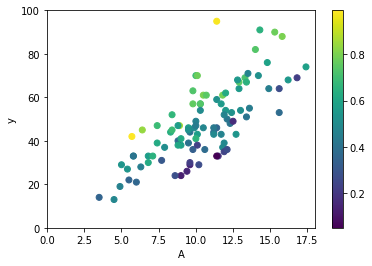

In [28]:
plt.scatter(d.A,d.y,c=d.x)
plt.colorbar()
plt.xlim(0,18)
plt.ylim(0,100)
plt.xlabel("A")
plt.ylabel("y")

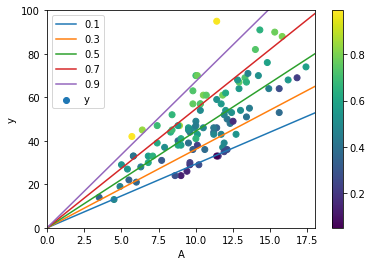

In [29]:
df_predict = pd.DataFrame()
df_predict["x"] = 0
df_predict["A"] = np.arange(0.1,20,0.1)
x_list = [0.1,0.3,0.5,0.7,0.9]

plt.scatter(d.A,d.y,c=d.x)
plt.colorbar()
plt.xlim(0,18)
plt.ylim(0,100)
plt.xlabel("A")
plt.ylabel("y")
for x in x_list:
    df_predict["x"] = x
    # predict内にてoffsetの設定必要。
    plt.plot(df_predict.A,result.predict(df_predict,offset=np.log(df_predict.A)),label=x)
plt.legend()

* 「単位面積当たり」ではなく、「単位時間当たり」の事象を調べたい時にも使える。
* カウントデータだけでなく、（連続値）/(連続値）となるような比率・密度などもオフセット項を使った統計モデリングが可能。

## 6.7. 正規分布とその尤度

* ポアソン分布や二項分布はカウントデータを扱う
* 正規分布(ガウス分布)は連続値のデータを統計モデルで扱うための確率分布

Q. 正規分布のパラメーターは？

A.
* 平均値 $\mu$
    * 範囲は$\pm \infty$
* 標準偏差 $\sigma$
    * 値のばらつきを表す

Q. 正規分布の確率分布関数は？

A.
* $p(y | \mu , \sigma) = \frac {1} {\sqrt{2 \pi \sigma^2}} \exp \left( - \frac {(y-\mu)^2}{2 \sigma^2} \right)$

### 確率密度の図示

* 縦軸は今までの離散確率分布の図示とは異なり、「確率分布」ではない。「確率密度」である。
* 連続値の確率分布では、確率密度を積分した量が確率と定義される。

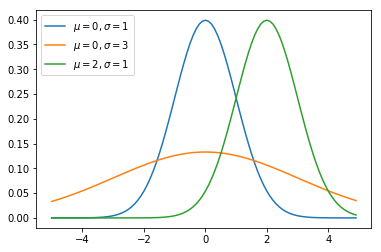

In [30]:
import scipy.stats as sct
y = np.arange(-5,5,0.1)
plt.plot(pd.Series(sct.norm.pdf(y, loc=0, scale=1), index=y), label=r'$\mu=0, \sigma=1$')
plt.plot(pd.Series(sct.norm.pdf(y, loc=0, scale=3), index=y), label=r'$\mu=0, \sigma=3$')
plt.plot(pd.Series(sct.norm.pdf(y, loc=2, scale=1), index=y), label=r'$\mu=2, \sigma=1$')
plt.legend()

* 横軸は$y$であることに注意。

### 確率の計算

* 確率を計算するには、平均$\mu$、標準偏差$\sigma$を指定し、調べたい確率の範囲を決める。

In [31]:
def menseki(begin, end, loc,scale):
    menseki_begin = sct.norm.cdf(x=begin,loc=loc,scale=scale)
    menseki_end = sct.norm.cdf(x=end,loc=loc,scale=scale)
    return menseki_end - menseki_begin

In [32]:
menseki(1.2,1.8,0,1)

0.079139351108782452

* 積分を用いずに面積を求める方法もある。
* 下限と上限の間の値$y = (1.2+1.8)/2 = 1.5$における、確率密度$p(y=1.5 | 0, 1)$を「高さ」、$\Delta y = 1.8 - 1.2 =0.6$を「幅」とする長方形であると近似してみる。

In [33]:
sct.norm.pdf(x=((1.2+1.8)/2),loc=0,scale=1) * (1.8-1.2)

0.077710557399535057

### 正規分布の最尤推定法について

* 確率=確率密度関数$\times \Delta y$という考え方に基づく。
* ある$y_i$が$y_i - 0.5\Delta y \leqq y \leqq y_i + 0.5\Delta y$である確率は、確率密度関数$p(y_i | \mu \sigma)$と区間幅$\Delta y$の積に近似できるので、尤度関数は下記。

$$
\begin {equation}
\begin {split}
L(\mu,\sigma) &= \prod_i p(y_i | \mu , \sigma)\Delta y \\
&= \prod_i \frac {1} {\sqrt{2 \pi \sigma^2}} \exp \left( - \frac {(y-\mu)^2}{2 \sigma^2} \right) \Delta y
\end {split}
\end {equation}
$$

* 対数尤度関数（仮）は下記になる

$$
\log L (\mu, \sigma)= -0.5N \log (2\pi \sigma^2) - \frac {1}{2\sigma^2} \sum_i (y_i-\mu)^2 + N \log(\Delta y)
$$

* 対数尤度関数(真）は下記。区間幅 $\Delta y$は定数なので、パラメーター{$\mu,\sigma$}の最尤推定値に影響を与えないので、上記は下記に書き換えられる。

$$
\log L (\mu, \sigma)= -0.5N \log (2\pi \sigma^2) - \frac {1}{2\sigma^2} \sum_i (y_i-\mu)^2
$$

* 尤度が確率密度の積である場合には、対数尤度は負の値になるとは限らない。
* 正規分布など連続値の確率分布を使った統計モデルでは対数尤度が正の値、AICや逸脱度が負の値になることもある。

### 最小二乗法と最尤推定法の関係

* 上の対数尤度関数をみると、$\mu,\sigma$が互いに無関係ない定数だとすると、$$\sum_{i} (y_i - \mu)^2$$を最小にする時、$\log L(\mu,\sigma)$が最大になる。これは最小二乗法による推定と等しくなる。
* 『3.7.「なんでも正規分布」「なんでも直線」には無理がある』で直線回帰について簡単に説明した。
    * これは、正規分布を部品とするGLMで、
        * 線形予測子$z_i = \beta_1 + \beta_2 x_i$
        * 恒等リンク関数を使い平均を$\mu_i =z_i$
    * 上記としたGLMの最尤推定法によるパラメーター推定と、
    * いわゆる「最小二乗法による直線の当てはめ」は同等なものとみなすことができる。
* （滝沢補足）上記では$\sigma$が出てこないことからも、標準偏差を無視してしまっていることがわかる。

## 6.8. ガンマ分布のGLM

Q. ガンマ分布(gamma distribution)とは？

A.
* 確率変数の取りうる範囲が0以上の連続確率分布

Q. ガンマ分布の確率密度関数は？

A. 
$$
p(y| s, r)=\frac {r^s} {\Gamma (s)} y^{s-1} \exp(-ry)
$$
* $s$ : shapeパラメーター
* $r$ : rateパラメーター
* $\Gamma(s)$ : ガンマ関数
* 平均は $s/r$ , 分散は$s/r^2$。つまり分散=平均$/r$
* $s=1$の時は指数分布(exponential distribution)

### GLM例題

* 架空植物 50個体
* 個体$i$の葉重量$x_i$、花重量を$y_i$とする。

* d.Rdataを読み込むために、csvに変換

In [34]:
# resave <- function(file){
#   e <- new.env(parent = emptyenv())
#   load(file, envir = e)
#   objs <- ls(envir = e, all.names = TRUE)
#   for(obj in objs) {
#     .x <- get(obj, envir =e)
#     message(sprintf('Saving %s as %s.csv', obj,obj) )
#     write.csv(.x, file = paste0(obj, '.csv'))
#   }
# }

#   resave('yourData.RData')

In [35]:
data = pd.read_csv("./input_6/d.csv",index_col=0)

In [36]:
data.head()

,x,y
1,0.001000,0.000887
2,0.017306,0.023465
3,0.033612,0.069876
4,0.049918,0.034340
5,0.066224,0.026520


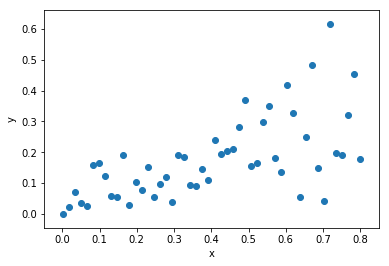

In [37]:
plt.scatter(data.x,data.y)
plt.xlabel("x")
plt.ylabel("y")

* $x_i$が大きくなるにつれ、$y_i$も大きくなっているようだ。
* 応答変数$y_i$は連続値ですが、重量なので正の値しかとらない。そのばらつきは正規分布ではなくガンマ分布で説明した方がよさそう。
* ある個体の花の重量$y_i$が平均$\mu_i$のガンマ分布に従っていることにする。


* 平均花重量$\mu_i$が葉重量$x_i$の単調増加関数であり、さらになんらかの生物学的な理由があって、
$$
\mu_i = A x_{i}^b
$$
と仮定したとする。
* この右辺で$A=\exp(a)$と置いてから、全体を指数関数でまとめてみます。
$$
\mu_i = \exp(a) x_{i}^b = \exp(a+b \log x_i)
$$
* 上記の両辺の対数を取る。
$$
\log \mu_i = a+b \log x_i
$$
* このように、線形予測子$a+b \log x_i$と対数リンク関数を使って平均$\mu_i$が与えられた。この線形予測子では説明変数は$x_i$ではなく$\log x_i$となり、推定すべきパラメーターは切片$a$と傾き$b$です。
* (わからない）上記の計算式の仮定（Aなど）がなぜ出てきたのかがわからない。

### ガンマ分布を当てはめる

In [38]:
model = smf.glm('y~np.log(x)',data=data,family=sm.families.Gamma(link=sm.families.links.log))

In [39]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                  0.325084320549
Method:                          IRLS   Log-Likelihood:                 58.471
Date:                Thu, 06 Jul 2017   Deviance:                       17.251
Time:                        01:08:14   Pearson chi2:                     15.6
No. Iterations:                    10                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0403      0.119     -8.759      0.000      -1.273      -0.808
np.log(x)      0.6832      0.068      9.992      0.000       0.549       0.817
==============================================================================
"""

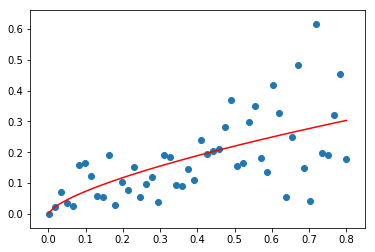

In [40]:
intercept = result.params["Intercept"]
nplog = result.params["np.log(x)"]
pred = np.exp(intercept + np.log(data.x) * nplog)
plt.scatter(data.x,data.y)
# plt.scatter(data.x,pred)
plt.plot(data.x,pred,c="red")

* または下記でも図示可能

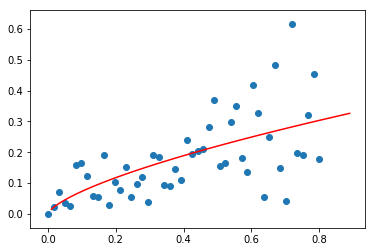

In [41]:
x_list = np.arange(0.01,0.9,0.01)
df_test = pd.DataFrame()
df_test["x"] = x_list
pred_y = result.predict(df_test.x)
plt.scatter(data.x,data.y)
plt.plot(x_list,pred_y,c="red")

* (わからない）Pythonだと、信頼区間を表示するのは難しい？
    * 確率分布に従ってサンプル点を多数起き、信頼区間のように見せる？

## 6.9. この章のまとめと参考文献

* GLMでは応答変数のばらつきを表現する確率分布は下記などから選択できる。
    * 正規分布
    * ポアソン分布
    * 二項分布
    * ガンマ分布
* 「$N$個の観察対象のうち$k$個で反応が見られた」というタイプのデータに見られるばらつきを表すために二項分布が使える。
* ロジスティック回帰
* 交互作用項
* 観測値同士の割り算値作成、応答変数変換の問題点。ロジスティック回帰やオフセット項の工夫をすれば、情報消失の原因となる「データの加工」は不要になる。
* 連続値の確率変数のばらつきを表現する確率分布
    * 正規分布
    * ガンマ分布

* 第7章以降ではGLMをさらに強化し、複雑な統計モデルをつくれるようにする。